<a href="https://colab.research.google.com/github/ua-datalab/GraphML/blob/main/04_29_GraphML_Lecture05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Graph ATtention networks (GATs)**

### **Before we start, change the Runtime to T4**

### Graph Attention Networks (GATs), a key advancement from Graph Convolutional Networks (GCNs)(**from Tutorial 4**).

### Unlike GCNs, which use static normalization coefficients, GATs employ dynamic weighting factors derived through a mechanism known as self-attention—a core feature in some of the most influential deep learning models, such as transformers, BERT, and GPT-3.

### First introduced by [Veličković et al.](https://arxiv.org/abs/1710.10903) in 2017, GATs have gained popularity for their robust performance right out of the box.

In this chapter, we will explore the following topics:

* Introduction to the graph attention layer
* Implementing the graph attention layer using NumPy
* Building a Graph Attention Network (GAT) with PyTorch Geometric



## Understanding Graph Attention Networks (GATs)

Graph Attention Networks (GATs) enhance the flexibility of graph neural networks by integrating node features into the weighting calculations, allowing for **dynamic attention scores** that surpass the **static weighting based solely on node degrees found in Graph Convolutional Networks** (GCNs).






---



---



## Graph Convolution vs. Graph Attention Layer

### Limitations of Graph Convolutions (from Tutorial 4)

### In traditional graph convolutional networks, the significance of nodes with fewer neighbors is amplified by the normalization coefficient. This coefficient is often calculated as:

$$ \frac{1}{\sqrt{\text{degree}(node_i) \times \text{degree}(node_j)}} $$




## Graph Attention layer

In contrast, the graph attention layer aims to produce weighting factors that incorporate both the structural context and the specific features of the nodes. These factors, referred to as "attention scores," dynamically evaluate the importance of each neighboring node. For nodes $ i $ and any node $ j $ in the neighborhood $ N(i) $, the graph attention operation is defined as:

$$ h_i = \sum_{j \in \mathcal{N}(i)} \alpha_{ij} W x_j $$


## Key Components of the Graph Attention Layer

### Linear Transformation
- **Purpose:** Each node feature undergoes a linear transformation, allowing for the integration of interactions between node pairs, which is critical for the layer's ability to focus on relevant information. This score takes into account the features from both nodes. In the graph attention layer, this relationship is captured by concatenating the hidden vectors of both nodes. The concatenated vector undergoes a linear transformation using a shared weight matrix $ W $, common for computing hidden vectors. This is further transformed by a dedicated, learnable weight matrix specifically designed to produce attention coefficients during the training process. This entire procedure is encapsulated by the following formula:

$$ a_{ij} = W_a [Wx_i \Vert Wx_j] $$

### Activation Function
- **Implementation:** Nonlinear functions such as Leaky ReLU are used to capture complex patterns that extend beyond simple linear combinations.
- **Significance:** Nonlinearity is essential in neural networks to approximate nonlinear target functions effectively.

The output from the previous step is then processed through a Leaky ReLU function. The **Leaky ReLU** introduces a small slope for negative values, allowing for a small, non-zero gradient when the unit is not active. This is represented by the equation:
$$ y = \max(0.01x, x) $$

![Image](https://miro.medium.com/v2/resize:fit:720/format:webp/0*6DZve_x3t08PcwYm.JPG)

### Softmax Normalization
- **Function:** Normalizes attention scores across all nodes to ensure they are comparable, which is crucial for the model's training stability.
- **Method:** Typically, the softmax function is employed for this purpose, scaling the attention scores in a way that they sum to one across the nodes' neighborhood.

To effectively compare attention scores across different nodes, we must normalize these values to ensure they are on the same scale. This normalization commonly uses the softmax function in machine learning. For node $ i $ and its neighboring nodes, including itself, the softmax function is applied to calculate the normalized attention scores. The softmax calculation for
$ \alpha_{ij} $ is given by:

$$ \alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{e^{e_{ij}}}{\sum_{k \in \mathcal{N}(i)} e^{e_{ik}}} $$


### Multi-head Attention
- **Inspiration:** Borrowed from transformer architectures, this technique uses multiple sets of attention mechanisms simultaneously to diversify the learning and enhance model stability.
- **Benefits:** Multi-head attention allows the model to capture various aspects of the data in parallel, improving performance and robustness.

Multi-head attention addresses the drawbacks of self-attention by diversifying the attention mechanism:

Multiple Embeddings: By calculating multiple sets of attention scores and corresponding embeddings, multi-head attention allows the model to explore different aspects of the data in parallel. Each "head" of attention can focus on different relationships in the data, capturing a broader range of features than a single set of attention scores could.

Combining Results:
Averaging: The outputs from multiple heads are averaged. This method reduces variance in the attention outputs, as it smooths out the extreme values that might be produced by any single attention head.

$$ h_i = \frac{1}{n} \sum_{k=1}^{n} h_i^k = \frac{1}{n} \sum_{k=1}^{n} \sum_{j \in N_i} \alpha_{ij}^k W^k x_j $$

Concatenation: Alternatively, the outputs from all heads are concatenated to form a larger feature space. This method preserves the distinct perspectives from each head, enhancing the model’s capacity to represent complex data relationships.

$$ h_i = \|_{k=1}^{n} h_i^k = \|_{k=1}^{n} \sum_{j \in N_i} \alpha_{ij}^k W^k x_j $$




---



---



## In matrix form:

$$ h_i = \sum_{j \in \mathcal{N}_i} \alpha_{ij} W x_j $$


## and the  graph attention layer can be written as
$$
H = \tilde{A}^TW_{\alpha} X W^T
$$

## **Implementing Graph Attention in Numpy**

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## Example

### Considering the following adjacency matrix $ A $;  with self loops version

In [2]:
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])


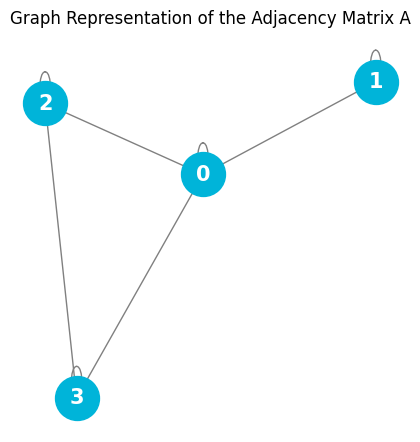

In [3]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(A)
mapping = {i: i  for i in range(len(G.nodes))}
G = nx.relabel_nodes(G, mapping)

# Draw the graph with labels starting from 1
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=True, font_color='#ffffff', node_size=1000, node_color="#00b4d9", font_size=15, font_weight='bold', edge_color='gray')
plt.title("Graph Representation of the Adjacency Matrix A")
plt.show()

### For feature vector: we generate from a normal distribution using numpy

In [4]:
X = np.random.uniform(-1, 1, (4, 4))

In [5]:
X

array([[-0.83138904,  0.14795564, -0.58015326,  0.60504443],
       [-0.34975839, -0.43945714, -0.16305606, -0.87422746],
       [-0.30119075, -0.56359775,  0.68631308,  0.750651  ],
       [ 0.33475158, -0.977144  ,  0.0493458 ,  0.03906593]])

Moving forward, we need to establish the weight matrices that are pivotal in graph attention layers. Specifically, there are two distinct matrices: the standard weight matrix, often denoted as
$ W $, and the weight matrix dedicated to attention, denoted as
${W}_{att}$ . While various initialization techniques exist, such as Xavier or He initialization, to tailor the matrices to optimize learning, in this instance, we can simply apply a uniform random initialization function for illustrative purposes.

In [6]:
W = np.random.uniform(-1, 1, (2, 4))
W

array([[ 0.69147076, -0.89047094, -0.53993022,  0.81700251],
       [ 0.01727098,  0.74841087,  0.49252491,  0.26758988]])

In [7]:
W_att = np.random.uniform(-1, 1, (1, 4))
W_att

array([[ 0.88761142, -0.20199502,  0.81996747,  0.62586948]])

## Getting source and destination nodes

In [8]:
connections = np.where(A > 0)
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

## Now, We can concatenate hidden vectors of source and destination nodes

In [9]:
np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1)

array([[ 0.10093369, -0.02746346,  0.10093369, -0.02746346],
       [ 0.10093369, -0.02746346, -0.47673102, -0.64917876],
       [ 0.10093369, -0.02746346,  0.5363254 ,  0.11188835],
       [ 0.10093369, -0.02746346,  1.10686294, -0.69076603],
       [-0.47673102, -0.64917876,  0.10093369, -0.02746346],
       [-0.47673102, -0.64917876, -0.47673102, -0.64917876],
       [ 0.5363254 ,  0.11188835,  0.10093369, -0.02746346],
       [ 0.5363254 ,  0.11188835,  0.5363254 ,  0.11188835],
       [ 0.5363254 ,  0.11188835,  1.10686294, -0.69076603],
       [ 1.10686294, -0.69076603,  0.10093369, -0.02746346],
       [ 1.10686294, -0.69076603,  0.5363254 ,  0.11188835],
       [ 1.10686294, -0.69076603,  1.10686294, -0.69076603]])

### Applying a linear transformation to this result with the attention matrix

In [10]:
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1).T

## Applying a Leaky ReLU function

In [11]:
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x)

e = leaky_relu(a)
e

array([[ 0.16071118, -0.14041354,  0.60493426,  0.57039961, -0.04528944,
        -0.21784523,  0.51902146,  0.96324454,  0.92870988,  1.18756929,
         1.63179237,  1.59725771]])

In [12]:
e.shape

(1, 12)

### This matrix should resemble $ \tilde{A} $   since unnormalized attention scores are redundant for node pairs that do not share a connection. We can construct this matrix accurately because the existing connections provide us with the necessary information about the source and destination nodes.

In [13]:
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0]
E

array([[ 0.16071118, -0.14041354,  0.60493426,  0.57039961],
       [-0.04528944, -0.21784523,  0.        ,  0.        ],
       [ 0.51902146,  0.        ,  0.96324454,  0.92870988],
       [ 1.18756929,  0.        ,  1.63179237,  1.59725771]])


### Adjust each row of attention scores to a standard scale by applying a tailored softmax function, which will yield our ultimate attention coefficients.

In [14]:
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

W_alpha = softmax2D(E, 1)
W_alpha

array([[0.20809004, 0.1539836 , 0.32447027, 0.31345609],
       [0.25418305, 0.21389792, 0.26595952, 0.26595952],
       [0.2145587 , 0.12768444, 0.33455672, 0.32320015],
       [0.22880215, 0.06977588, 0.35676623, 0.34465575]])


The attention matrix
$ α  $ assigns weights to every potential link within the network. Utilizing this matrix, we can compute our embedding matrix
$ H $, resulting in two-dimensional vector representations for each node.

In [15]:
H = A.T @ W_alpha @ X @ W.T

In [16]:
H

array([[ 1.88988813, -1.11003933],
       [ 0.82927455, -0.58569489],
       [ 1.52918269, -0.81024257],
       [ 1.52918269, -0.81024257]])

Our graph attention layer is fully assembled! To incorporate multi-head attention, we replicate the process using varied instances of weight matrices and attention mechanisms, followed by a combination of their outputs.



---



---



## **GAT in PyTorch Geometric** - Working out examples from previous Tutorials

In [17]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00


In [19]:
from torch_geometric.datasets import Planetoid,FacebookPagePage
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

**The Cora Dataset**

In [20]:
# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]
degrees = degree(data.edge_index[0]).numpy()

Processing...
Done!


In [21]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout

In [22]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [23]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [24]:
# Create the GAT model
gat = GAT(dataset.num_features, 16, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 16, heads=8)
  (gat2): GATv2Conv(128, 7, heads=1)
)
Epoch   0 | Train Loss: 1.983 | Train Acc: 12.14% | Val Loss: 1.98 | Val Acc: 10.60%
Epoch  20 | Train Loss: 0.186 | Train Acc: 99.29% | Val Loss: 0.87 | Val Acc: 74.20%
Epoch  40 | Train Loss: 0.152 | Train Acc: 97.86% | Val Loss: 0.86 | Val Acc: 72.40%
Epoch  60 | Train Loss: 0.167 | Train Acc: 97.14% | Val Loss: 0.84 | Val Acc: 76.40%
Epoch  80 | Train Loss: 0.144 | Train Acc: 100.00% | Val Loss: 0.82 | Val Acc: 74.40%
Epoch 100 | Train Loss: 0.143 | Train Acc: 98.57% | Val Loss: 0.77 | Val Acc: 75.20%
GAT test accuracy: 83.30%


**The FB Page-Page dataset**

In [25]:
# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")
data = dataset[0]

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

Processing...
Done!


In [26]:
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(128, 32, heads=8)
  (gat2): GATv2Conv(256, 4, heads=1)
)


In [27]:
# Train
gat.fit(data, epochs=100)

# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

Epoch   0 | Train Loss: 1.798 | Train Acc: 27.40% | Val Loss: 1.82 | Val Acc: 26.86%
Epoch  20 | Train Loss: 0.364 | Train Acc: 87.23% | Val Loss: 0.36 | Val Acc: 87.29%
Epoch  40 | Train Loss: 0.350 | Train Acc: 88.49% | Val Loss: 0.34 | Val Acc: 89.04%
Epoch  60 | Train Loss: 0.341 | Train Acc: 88.21% | Val Loss: 0.34 | Val Acc: 88.44%
Epoch  80 | Train Loss: 0.331 | Train Acc: 88.91% | Val Loss: 0.33 | Val Acc: 89.39%
Epoch 100 | Train Loss: 0.340 | Train Acc: 88.40% | Val Loss: 0.34 | Val Acc: 88.69%
GAT test accuracy: 91.45%


GAT on the CiteSeer and Pubmed dataset from Tutorial 3

In [28]:
dataset_CSeer = Planetoid(root=".", name="CiteSeer")
data_graph_CSeer = dataset_CSeer[0] # get the citeseer graph

dataset_PM = Planetoid(root=".", name="PubMed")
data_graph_PM = dataset_PM[0] # the Pubmed graph

Processing...
Done!
Processing...
Done!


**GAT on Citeseer**

In [29]:
gat = GAT(dataset_CSeer.num_features, 32, dataset_CSeer.num_classes)
print(gat)

GAT(
  (gat1): GATv2Conv(3703, 32, heads=8)
  (gat2): GATv2Conv(256, 6, heads=1)
)


In [30]:
# Train
gat.fit(data_graph_CSeer, epochs=100)

Epoch   0 | Train Loss: 1.795 | Train Acc: 20.00% | Val Loss: 1.80 | Val Acc: 18.20%
Epoch  20 | Train Loss: 0.178 | Train Acc: 96.67% | Val Loss: 1.21 | Val Acc: 60.80%
Epoch  40 | Train Loss: 0.159 | Train Acc: 96.67% | Val Loss: 1.22 | Val Acc: 56.60%
Epoch  60 | Train Loss: 0.114 | Train Acc: 100.00% | Val Loss: 1.21 | Val Acc: 60.60%
Epoch  80 | Train Loss: 0.109 | Train Acc: 100.00% | Val Loss: 1.25 | Val Acc: 59.80%
Epoch 100 | Train Loss: 0.083 | Train Acc: 99.17% | Val Loss: 1.17 | Val Acc: 62.80%


In [31]:
# Test
acc = gat.test(data_graph_CSeer)
print(f'\nGAT test accuracy on CiteSeer Dataset: {acc*100:.2f}%\n')


GAT test accuracy on CiteSeer Dataset: 68.90%



In [32]:
# @title Model Comparison
%%html
<table style="width:70%; margin-left:auto; margin-right:auto;" border="1">
  <tr style="background-color: #f2f2f2;">
    <th style="padding: 10px; text-align:center;">Dataset</th>
    <th style="padding: 10px; text-align:center;">MLP (Tutorial 3)</th>
    <th style="padding: 10px; text-align:center;">Vanilla GNN (Tutorial 3)</th>
    <th style="padding: 10px; text-align:center;">GCN (Tutorial 4)</th>
    <th style="padding: 10px; text-align:center;">GAT </th>
  </tr>
  <tr>
    <td style="padding: 10px; text-align:center;">Cora</td>
    <td style="padding: 10px; text-align:center;">53.40%</td>
    <td style="padding: 10px; text-align:center;">75.00%</td>
    <td style="padding: 10px; text-align:center;">80.60%</td>
    <td style="padding: 10px; text-align:center;">83.30%</td>
  </tr>
  <tr style="background-color: #f9f9f9;">
    <td style="padding: 10px; text-align:center;">Facebook Page-Page</td>
    <td style="padding: 10px; text-align:center;">75.13%</td>
    <td style="padding: 10px; text-align:center;">82.67%</td>
    <td style="padding: 10px; text-align:center;">91.21%</td>
    <td style="padding: 10px; text-align:center;">91.45%</td>
  </tr>
  <tr>
    <td style="padding: 10px; text-align:center;">CiteSeer</td>
    <td style="padding: 10px; text-align:center;">52.70%</td>
    <td style="padding: 10px; text-align:center;">65.50%</td>
    <td style="padding: 10px; text-align:center;">68.10%</td>
    <td style="padding: 10px; text-align:center;">68.90%</td>
  </tr>
</table>

Dataset,MLP (Tutorial 3),Vanilla GNN (Tutorial 3),GCN (Tutorial 4),GAT
Cora,53.40%,75.00%,80.60%,83.30%
Facebook Page-Page,75.13%,82.67%,91.21%,91.45%
CiteSeer,52.70%,65.50%,68.10%,68.90%


## **Node Regression**

**Refer to Tutorial 4 for details of the Wikipedia Dataset**

In [33]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

In [34]:
dataset = WikipediaNetwork(root=".", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))

Processing...
Done!


In [61]:
data = dataset[0]

In [62]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


In [63]:
data.to(device)

Data(x=[2277, 2325], edge_index=[2, 36101], y=[2277], train_mask=[2277], val_mask=[2277], test_mask=[2277])

In [64]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [65]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [66]:
import pandas as pd
import torch
df = pd.read_csv('/content/wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

In [67]:
device

device(type='cuda')

In [68]:
# Assuming 'data' is an object or dictionary containing 'x', 'y', and masks
# data.x = data.x.to(device)
data.y = data.y.to(device)
# data.train_mask = data.train_mask.to(device)
# data.val_mask = data.val_mask.to(device)

In [69]:
data.y = data.y.to(torch.float32).flatten().unsqueeze(1)

In [70]:
data.y.shape

torch.Size([2277, 1])

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

## **GAT on Wikipedia Chamelon Dataset**

In [71]:
class GATreg(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h*4)
        self.gat2 = GATv2Conv(dim_h*4, dim_h*2)
        self.gat3 = GATv2Conv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gat1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gat2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gat3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(),lr=0.02,weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

In [72]:
data.y.shape

torch.Size([2277, 1])

In [73]:
data.y = data.y.to(torch.float32).flatten()

In [94]:
# Create the Vanilla GNN model
gat = GATreg(dataset.num_features, 256, 1).to(device)
print(gat)

GATreg(
  (gat1): GATv2Conv(2325, 1024, heads=1)
  (gat2): GATv2Conv(1024, 512, heads=1)
  (gat3): GATv2Conv(512, 256, heads=1)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


In [95]:
gat.to(device)

GATreg(
  (gat1): GATv2Conv(2325, 1024, heads=1)
  (gat2): GATv2Conv(1024, 512, heads=1)
  (gat3): GATv2Conv(512, 256, heads=1)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [96]:
data.x = data.x.to(device)
data.y = data.y.to(device)
data.train_mask = data.train_mask.to(device)
data.val_mask = data.val_mask.to(device)

In [97]:
# Train
gat.fit(data, epochs=200)

Epoch   0 | Train Loss: 11.74721 | Val Loss: 11.38480
Epoch  20 | Train Loss: 4.39063 | Val Loss: 3.70110
Epoch  40 | Train Loss: 1.01277 | Val Loss: 1.66626
Epoch  60 | Train Loss: 2.81941 | Val Loss: 1.10955
Epoch  80 | Train Loss: 0.47918 | Val Loss: 0.66514
Epoch 100 | Train Loss: 0.36154 | Val Loss: 0.68024
Epoch 120 | Train Loss: 0.40567 | Val Loss: 0.74111
Epoch 140 | Train Loss: 0.34980 | Val Loss: 0.76104
Epoch 160 | Train Loss: 0.43728 | Val Loss: 0.76894
Epoch 180 | Train Loss: 0.31224 | Val Loss: 0.64963
Epoch 200 | Train Loss: 0.30172 | Val Loss: 0.68591


In [98]:
# Test
loss = gat.test(data)
print(f'\nGAT test loss: {loss:.5f}\n')


GAT test loss: 0.50959



In [99]:
out = gat(data.x, data.edge_index)

In [100]:
out = out.cpu()

In [101]:
y_pred = out.squeeze()[data.test_mask.cpu()].detach().numpy()

In [102]:
mse = mean_squared_error(data.y[data.test_mask].squeeze().cpu(), y_pred)
mae = mean_absolute_error(data.y[data.test_mask].squeeze().cpu(), y_pred)

In [103]:
print('=' * 13 + '  GAT Wikipedia Chameleon Dataset  ' + '=' * 13)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 57)

=============  GAT Wikipedia Chameleon Dataset  =============
MSE = 0.5096 | RMSE = 0.7139 | MAE = 0.5634


| Model & Dataset                          | MSE  ⬇  | RMSE  ⬇ | MAE  ⬇  |
|------------------------------------------|--------|--------|--------|
| **MLP** on Wikipedia Chameleon Dataset       | 1.0280 | 1.0139 | 0.7373 |
| **GCN** on Wikipedia Chameleon Dataset        | 0.5947 | 0.7711 | 0.6059 |
| **GAT** on Wikipedia Chameleon Dataset        | 0.5096 | 0.7139 | 0.5634 |

**Thank you!**